In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#数据读取
file_path = '/Users/86180/Desktop/赛题B/全部数据/附件2-行业日负荷数据.csv'
data = pd.read_csv(file_path,parse_dates=['数据时间'],index_col=[1])

#数据分解
#大工业great，非普ind，商业com
data_great= data.loc[data['行业类型']=='大工业用电'].drop('行业类型',axis = 1)
data_ind=data.loc[data['行业类型']=='非普工业'].drop('行业类型',axis = 1)
data_ord=data.loc[data['行业类型']=='普通工业'].drop('行业类型',axis = 1)
data_com=data.loc[data['行业类型']=='商业'].drop('行业类型',axis = 1)

data_great_max = data_great.drop('有功功率最小值（kw）',axis = 1)
data_great_min = data_great.drop('有功功率最大值（kw）',axis = 1)
data_ind_max = data_ind.drop('有功功率最小值（kw）',axis = 1)
data_ind_min = data_ind.drop('有功功率最大值（kw）',axis = 1)
data_ord_max = data_ord.drop('有功功率最小值（kw）',axis = 1)
data_ord_min = data_ord.drop('有功功率最大值（kw）',axis = 1)
data_com_max = data_com.drop('有功功率最小值（kw）',axis = 1)
data_com_min = data_com.drop('有功功率最大值（kw）',axis = 1)

In [3]:
great_max = data_great_max.resample('D').mean()
great_min = data_great_min.resample('D').mean()
ind_max = data_ind_max.resample('D').mean()
ind_min = data_ind_min.resample('D').mean()
ord_max = data_ord_max.resample('D').mean()
ord_min = data_ord_min.resample('D').mean()
com_max = data_com_max.resample('D').mean()
com_min = data_com_min.resample('D').mean()

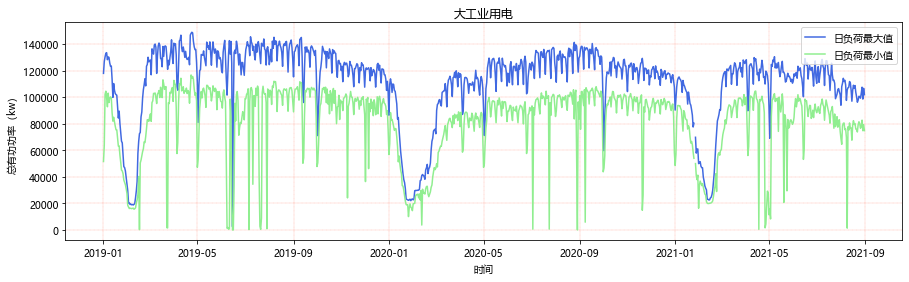

In [20]:
plt.rcParams['font.family'] = ['Microsoft YaHei']
plt.figure(figsize=(15,4))
plt.grid(color = 'tomato', linestyle = '--', linewidth = 0.25)
plt.plot(great_max, label='日负荷最大值', color='royalblue')
plt.plot(great_min, label='日负荷最小值', color='lightgreen')
plt.title('大工业用电')
plt.ylabel('总有功功率（kw）')
plt.xlabel('时间')
plt.legend(loc=1)
plt.savefig('/Users/86180/Desktop/B题 2.1 突变点检测-全部数据/原始数据/大工业用电.svg',format='svg')

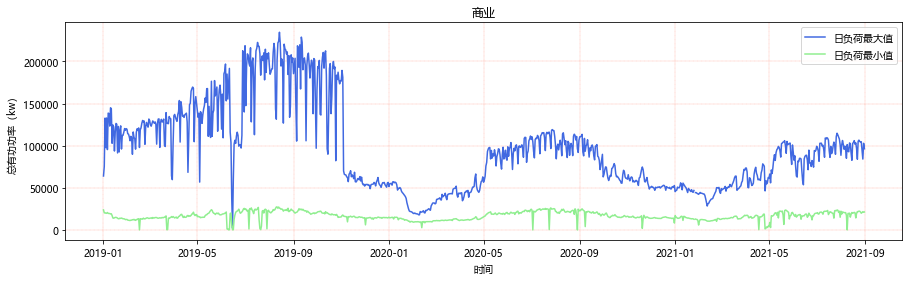

In [5]:
plt.rcParams['font.family'] = ['Microsoft YaHei']
plt.figure(figsize=(15,4))
plt.grid(color = 'tomato', linestyle = '--', linewidth = 0.25)
plt.plot(com_max, label='日负荷最大值', color='royalblue')
plt.plot(com_min, label='日负荷最小值', color='lightgreen')
plt.title('商业')
plt.ylabel('总有功功率（kw）')
plt.xlabel('时间')
plt.legend()
#plt.savefig('/Users/86180/Desktop/B题 2.1 突变点检测-全部数据/原始数据/商业.svg',format='svg')

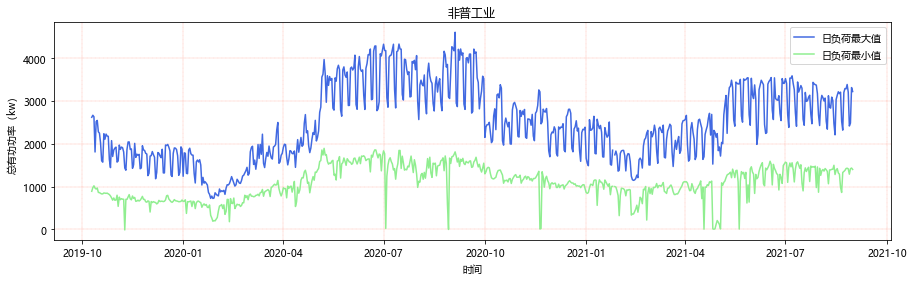

In [6]:
plt.rcParams['font.family'] = ['Microsoft YaHei']
plt.figure(figsize=(15,4))
plt.grid(color = 'tomato', linestyle = '--', linewidth = 0.25)
plt.plot(ind_max, label='日负荷最大值', color='royalblue')
plt.plot(ind_min, label='日负荷最小值', color='lightgreen')
plt.title('非普工业')
plt.ylabel('总有功功率（kw）')
plt.xlabel('时间')
plt.legend()
#plt.savefig('/Users/86180/Desktop/B题 2.1 突变点检测-全部数据/原始数据/非普工业.svg',format='svg')

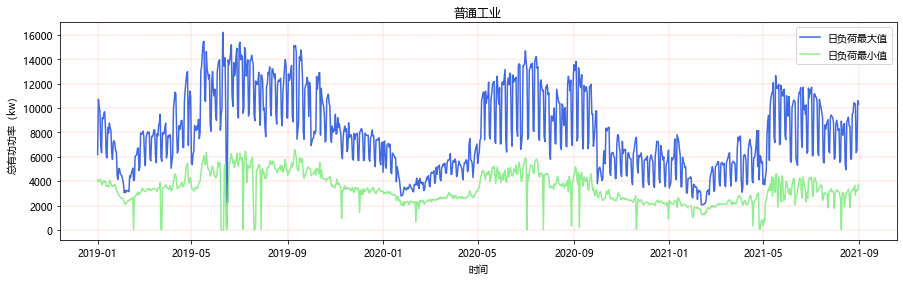

In [7]:
plt.rcParams['font.family'] = ['Microsoft YaHei']
plt.figure(figsize=(15,4))
plt.grid(color = 'tomato', linestyle = '--', linewidth = 0.25)
plt.plot(ord_max, label='日负荷最大值', color='royalblue')
plt.plot(ord_min, label='日负荷最小值', color='lightgreen')
plt.title('普通工业')
plt.ylabel('总有功功率（kw）')
plt.xlabel('时间')
plt.legend()
#plt.savefig('/Users/86180/Desktop/B题 2.1 突变点检测-全部数据/原始数据/普通工业.svg',format='svg')

In [8]:
def process(data):
    # 重采样D
    # 将有断点的时间序列变成连续时间序列
    data_fill = data.resample('D').mean()
    # 用中位数填充空缺值
    data_fill[data_fill.isna().iloc[:,0]] = data.median()
    # 将每天的减去每天中位数，使所有点的的功率变化都在一条水平线上
    data_day_median = data_fill.median().values
    data_values = [data_fill.iloc[i,0] - data_day_median[0] for i in range(data_fill.shape[0])]
    #plt.plot(data_values)
    
    # 利用正态分布的3σ原则，得出异常点
    data_values = pd.Series(data_values)
    mean = data_values.mean()
    std = data_values.std()
    rule=(mean-3*std > data_values) | (mean+3*std < data_values)
    #rule.sum()
    # 先用中位数填充异常点，使异常点落在大部分取值范围中
    data_del_wrong = data_values
    data_del_wrong[rule] = data_values.median()
    #plt.plot(data_del_wrong[:])
    # 再用滑动平均数去给异常点赋值，使异常点的数值与周围5个点的数值连续
    data_del_wrong[rule] = pd.Series(data_del_wrong).rolling(5, center=True).mean()[rule]
    
    #先用五天平均值作为一个数据点
    data_rsp5D= data_del_wrong[:data_del_wrong.shape[0]//5-1]
    for i in range(data_del_wrong.shape[0]//5):
        sum=0
        for j in range(5):
            sum+=data_del_wrong[5*i+j]
        data_rsp5D[i]= sum / 5
        
    # 用滑动窗口，使曲线平滑，去除噪声
    window = 2
    data_smooth = pd.Series(data_rsp5D).rolling(window, center=True).mean()
    # 用滑动窗口给data_smooth数据两边各有window//2个的np.NaN值填充
    for i in range(window//2):
        sum=0
        for j in range(i+1):
            sum+=data_values[j]
        data_smooth[i] = sum / (i+1)
    for i in range(window//2):
        sum=0
        for j in range(i+1):
            sum+=data_values[len(data_smooth) - j - 1]
        data_smooth[len(data_smooth) - i - 1] = sum / (i+1)    
   
    return data_smooth


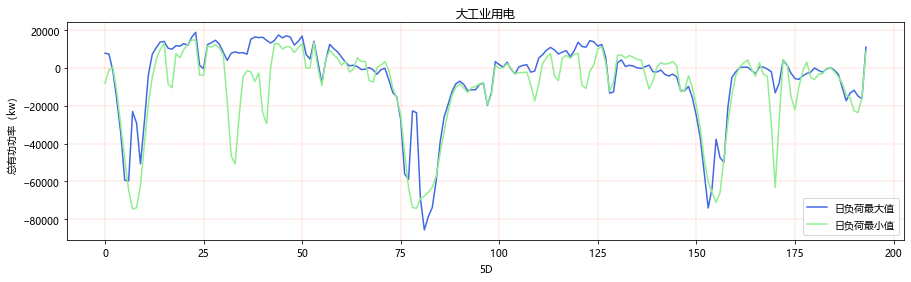

In [12]:
#处理＋画图

data_greatmax = process(data_great_max)
data_greatmin = process(data_great_min)
plt.rcParams['font.family'] = ['Microsoft YaHei']
plt.figure(figsize=(15,4))
plt.grid(color = 'tomato', linestyle = '--', linewidth = 0.25)
plt.plot(data_greatmax, label='日负荷最大值', color='royalblue')
plt.plot(data_greatmin, label='日负荷最小值', color='lightgreen')
plt.title('大工业用电')
plt.ylabel('总有功功率（kw）')
plt.xlabel('5D')
plt.legend()
#plt.savefig('/Users/86180/Desktop/B题 2.1 突变点检测-全部数据/大工业用电.svg',format='svg')


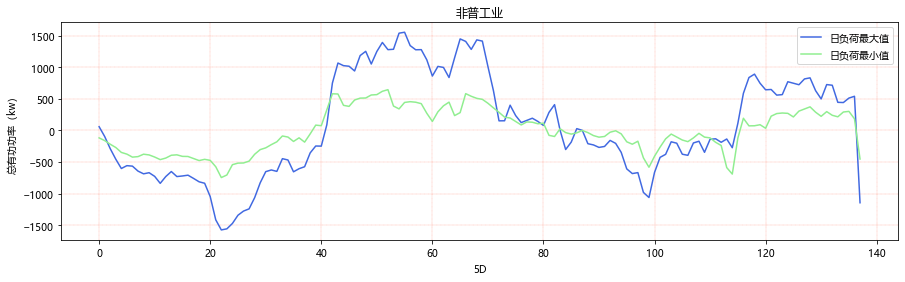

In [13]:
#处理＋画图

data_indmax = process(data_ind_max)
data_indmin = process(data_ind_min)
plt.rcParams['font.family'] = ['Microsoft YaHei']
plt.figure(figsize=(15,4))
plt.grid(color = 'tomato', linestyle = '--', linewidth = 0.25)
plt.plot(data_indmax, label='日负荷最大值', color='royalblue')
plt.plot(data_indmin, label='日负荷最小值', color='lightgreen')
plt.title('非普工业')
plt.ylabel('总有功功率（kw）')
plt.xlabel('5D')
plt.legend()
#plt.savefig('/Users/86180/Desktop/B题 2.1 突变点检测-全部数据/非普工业.svg',format='svg')


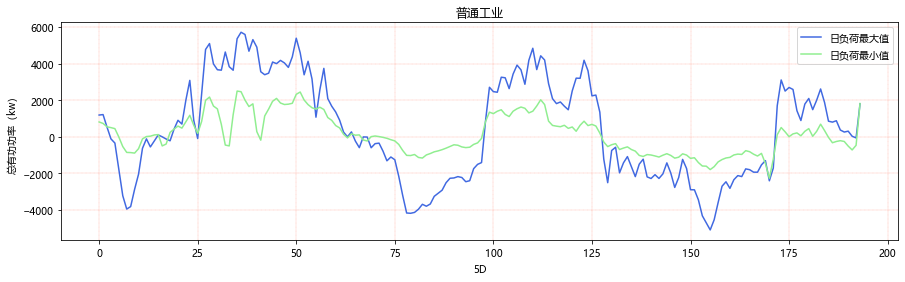

In [14]:
#处理＋画图

data_ordmax = process(data_ord_max)
data_ordmin = process(data_ord_min)
plt.rcParams['font.family'] = ['Microsoft YaHei']
plt.figure(figsize=(15,4))
plt.grid(color = 'tomato', linestyle = '--', linewidth = 0.25)
plt.plot(data_ordmax, label='日负荷最大值', color='royalblue')
plt.plot(data_ordmin, label='日负荷最小值', color='lightgreen')
plt.title('普通工业')
plt.ylabel('总有功功率（kw）')
plt.xlabel('5D')
plt.legend()
#plt.savefig('/Users/86180/Desktop/B题 2.1 突变点检测-全部数据/普通工业.svg',format='svg')


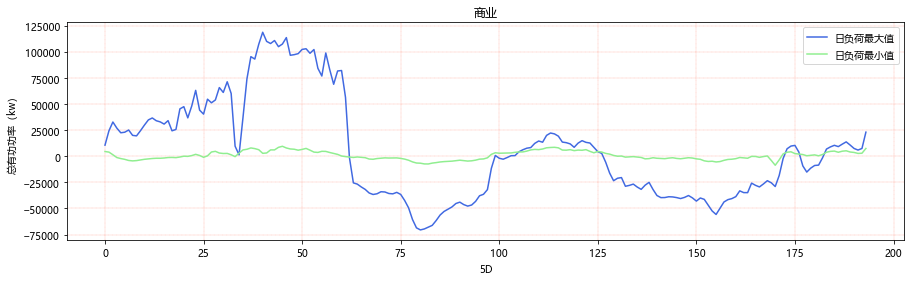

In [15]:
#处理＋画图

data_commax = process(data_com_max)
data_commin = process(data_com_min)
plt.rcParams['font.family'] = ['Microsoft YaHei']
plt.figure(figsize=(15,4))
plt.grid(color = 'tomato', linestyle = '--', linewidth = 0.25)
plt.plot(data_commax, label='日负荷最大值', color='royalblue')
plt.plot(data_commin, label='日负荷最小值', color='lightgreen')
plt.title('商业')
plt.ylabel('总有功功率（kw）')
plt.xlabel('5D')
plt.legend()
#plt.savefig('/Users/86180/Desktop/B题 2.1 突变点检测-全部数据/商业.svg',format='svg')


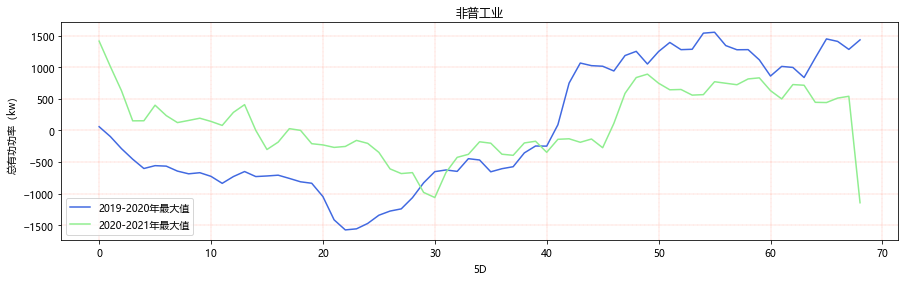

In [16]:
ind2 = np.array(data_indmax[69:])
ind1 = np.array(data_indmax[:69])

plt.rcParams['font.family'] = ['Microsoft YaHei']
plt.figure(figsize=(15,4))
plt.grid(color = 'tomato', linestyle = '--', linewidth = 0.25)
plt.plot(ind1, label='2019-2020年最大值', color='royalblue')
plt.plot(ind2, label='2020-2021年最大值', color='lightgreen')
#plt.plot(com3, label='2021年最大值', color='tomato')
plt.title('非普工业')
plt.ylabel('总有功功率（kw）')
plt.xlabel('5D')
plt.legend()
plt.savefig('/Users/86180/Desktop/非普工业同比图.svg',format='svg')

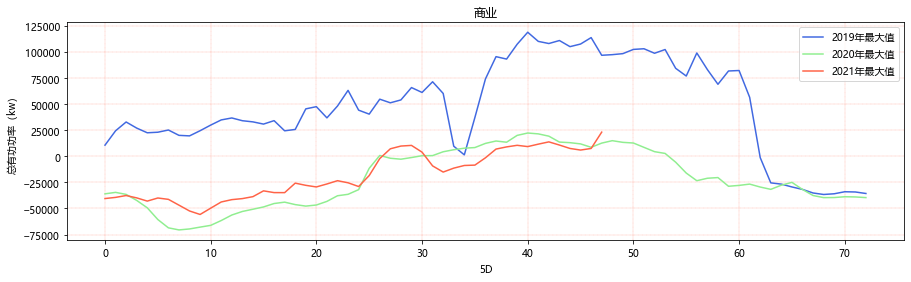

In [18]:
com1 = np.array(data_commax[:73])
com2 = np.array(data_commax[73:146])
com3 = np.array(data_commax[146:])


plt.rcParams['font.family'] = ['Microsoft YaHei']
plt.figure(figsize=(15,4))
plt.grid(color = 'tomato', linestyle = '--', linewidth = 0.25)
plt.plot(com1, label='2019年最大值', color='royalblue')
plt.plot(com2, label='2020年最大值', color='lightgreen')
plt.plot(com3, label='2021年最大值', color='tomato')
plt.title('商业')
plt.ylabel('总有功功率（kw）')
plt.xlabel('5D')
plt.legend()
#plt.savefig('/Users/86180/Desktop/非普工业同比图.svg',format='svg')